In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from sklearn.cluster import DBSCAN

import umap
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

import warnings
warnings.filterwarnings("ignore")


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

import warnings
warnings.filterwarnings("ignore")

# Cargar bases
df_tfidf = pd.read_parquet("Database/01_bbdd_think_tanks.parquet")
df_bert = pd.read_parquet("Database/01_bbdd_think_tanks_no_stopwords.parquet")

# Filtrar Signos Uandes
df_tfidf = df_tfidf[df_tfidf["Think Tank"] == "Signos Uandes"].copy()
df_bert = df_bert[df_bert["Think Tank"] == "Signos Uandes"].copy()

# Asegurar fechas
df_tfidf["FechaPublicacion"] = pd.to_datetime(df_tfidf["FechaPublicacion"], errors="coerce")
df_bert["FechaPublicacion"] = pd.to_datetime(df_bert["FechaPublicacion"], errors="coerce")
df_tfidf["año"] = df_tfidf["FechaPublicacion"].dt.year


In [3]:
df_bert.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4239 entries, 18731 to 22969
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ID                    4239 non-null   int64         
 1   Think Tank            4239 non-null   object        
 2   Tipo de Think Tank    4239 non-null   object        
 3   Orientación Política  4239 non-null   object        
 4   Autor                 4239 non-null   object        
 5   Título                4239 non-null   object        
 6   Medio                 0 non-null      object        
 7   Corpus                4239 non-null   object        
 8   Producto              4239 non-null   object        
 9   Enlace                4239 non-null   object        
 10  CorpusPDF             4239 non-null   object        
 11  FechaPublicacion      4239 non-null   datetime64[ns]
 12  Año                   4239 non-null   float64       
 13  Mes               

In [4]:
df_tfidf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4239 entries, 18731 to 22969
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ID                    4239 non-null   int64         
 1   Think Tank            4239 non-null   object        
 2   Tipo de Think Tank    4239 non-null   object        
 3   Orientación Política  4239 non-null   object        
 4   Autor                 4239 non-null   object        
 5   Título                4239 non-null   object        
 6   Medio                 0 non-null      object        
 7   Producto              4239 non-null   object        
 8   Enlace                4239 non-null   object        
 9   FechaPublicacion      4239 non-null   datetime64[ns]
 10  Año                   4239 non-null   float64       
 11  Mes                   4239 non-null   float64       
 12  Dia                   4239 non-null   float64       
 13  TextoLimpio       

Publicaciones totales: 4239
Años disponibles: [2024 2023 2022 2021 2020 2019 2018]


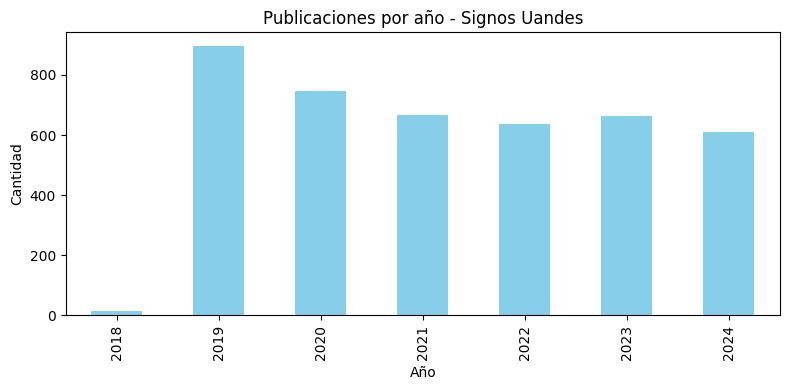

In [5]:
print("Publicaciones totales:", len(df_tfidf))
print("Años disponibles:", df_tfidf["año"].unique())

plt.figure(figsize=(8, 4))
df_tfidf["año"].value_counts().sort_index().plot(kind="bar", color="skyblue")
plt.title("Publicaciones por año - Signos Uandes")
plt.xlabel("Año")
plt.ylabel("Cantidad")
plt.tight_layout()
plt.show()


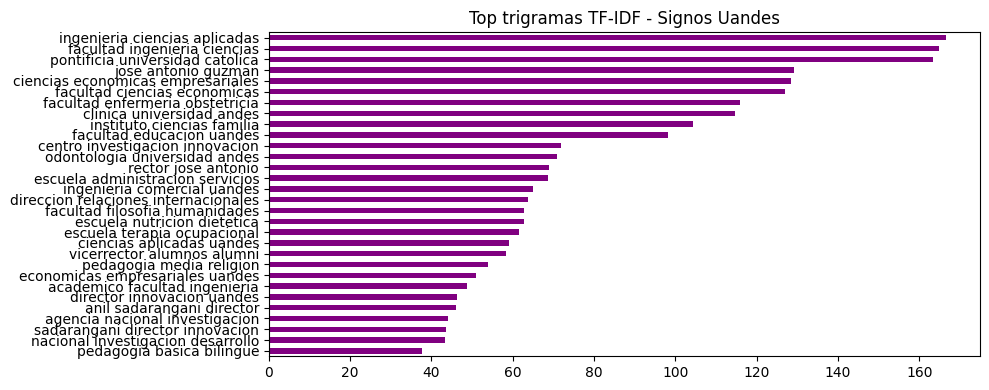

In [6]:
vectorizer = TfidfVectorizer(ngram_range=(3, 3), max_features=30)
X_tfidf = vectorizer.fit_transform(df_tfidf["TextoLimpio"].fillna(""))

tfidf_terms = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
top_trigrams = tfidf_terms.sum().sort_values(ascending=False)

plt.figure(figsize=(10, 4))
top_trigrams.plot(kind="barh", color="purple")
plt.title("Top trigramas TF-IDF - Signos Uandes")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [9]:
MODEL_NAME = "finiteautomata/beto-emotion-analysis"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.eval()

EMO_LABELS = list(model.config.id2label.values())
EMO_LABELS_PLOT = [e for e in EMO_LABELS if e.lower() != "others"]


In [10]:
def detectar_emocion_larga(texto, maxlen=512):
    chunks = [texto[i:i+maxlen] for i in range(0, len(texto), maxlen)]
    scores = torch.zeros(len(EMO_LABELS))
    with torch.no_grad():
        for chunk in chunks:
            inputs = tokenizer(chunk, return_tensors="pt", truncation=True)
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            scores += probs[0]
    return EMO_LABELS[torch.argmax(scores).item()]


In [11]:
# Aplica solo si no lo habías hecho aún
df_bert = df_bert[df_bert["Texto"].notnull()].copy()
df_bert["Emocion"] = df_bert["Texto"].apply(lambda x: detectar_emocion_larga(str(x)[:2000]))
